# Анализ результатов А/B-тестирования сайта пекарни

Мы хотим усилить визуальный контент на нашем сайте. Есть идея, что если мы добавим видео производства наших изделий, то пользователь будет принимать решение о покупке охотнее и быстрее, и конверсия в заказ вырастет. 

__Продакт вернул нам такой дизайн эксперимента:__

*1. `Бизнес-проблема:`* мы считаем, что конверсии из визита в покупку в нашей пекарне недостаточно высоки. Мы посмотрели на страницы конкурентов и поняли, что у нас есть возможность увеличить объем продаж, если мы изменим дизайн страницы с каталогом продукции.

*2. `Гипотеза:`* предполагается, что добавление видео с процессом приготовления вкусностей мотивирует к их покупке и позволяет добиться двух эффектов:
   * повышение конверсии из визита в оплату (больше людей захотят купить нашу продукцию)
   * как минимум, не снижение среднего чека покупки, а в идеале — увеличение
    
*3. `Ожидаемые действия пользователей:`* мы ожидаем, что, увидев видео с процессом приготовления вкусностей вместе с описанием продукции, больше людей захотят сделать покупку, а возможно — в среднем будут покупать больше продукции в одном заказе.

*4. `Эксперимент будет считаться успешным, если:`*
   * конверсия из визита в покупку с окном в 7 дней повысится
   * средний чек покупки не снизится


## Что нужно сделать?

Проанализировать данные теста и дать свои комментарии о его успешности. Можно ли выкатывать изменение на всех пользователей?

1. Выбрать окно конверсии
2. Исследовать распределение пользователей по группам по основным сегментам
3. Оценить статистическую значимость в изменении конверсии с помощью критерия хи-квадрат
4. Вычислить мощность теста
5. Использовать бутстрап для оценки влияния теста на средний чек
6. Сделать вывод по результатам проведенного теста

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1. Выбор окна конверсии на основе исторических данных

**1. Подлючаемся к историческим данным.**

In [2]:
historical_data = pd.read_csv('investigate_window.csv', parse_dates = [2,3], index_col = 0)

historical_data.head()

,user_id,main_page_viewed_at,order_completed_at,time_to_order
0,959238,2020-11-20 23:55:02.759000+00:00,2020-11-30 02:22:32.759000+00:00,9.102431
1,337366,2020-12-05 23:41:42.244000+00:00,2020-12-12 22:25:52.244000+00:00,6.947338
2,259956,2020-11-20 23:33:53.269000+00:00,2020-11-25 13:08:03.269000+00:00,4.565394
3,534280,2020-11-28 23:44:56.556000+00:00,2020-12-05 10:14:06.556000+00:00,6.436921
4,795121,2020-11-18 23:59:56.236000+00:00,2020-11-27 02:38:16.236000+00:00,8.109954


In [3]:
historical_data.dtypes

user_id                              int64
main_page_viewed_at    datetime64[ns, UTC]
order_completed_at     datetime64[ns, UTC]
time_to_order                      float64
dtype: object

**2. Вычисляем, какой перцентиль соответствует недельному окну конверсии.**

In [4]:
np.percentile(historical_data['time_to_order'], 95)

7.117476851851854

In [5]:
np.percentile(historical_data['time_to_order'], 90)

2.864949845679016

In [6]:
np.percentile(historical_data['time_to_order'], 85)

1.9903886959876527

In [7]:
# недельное окно конверсии

perc_95 = round(np.percentile(historical_data['time_to_order'], 95), 1)

**3. Строим гистограмму распределения времени между первым заходом на сайт и покупкой.**

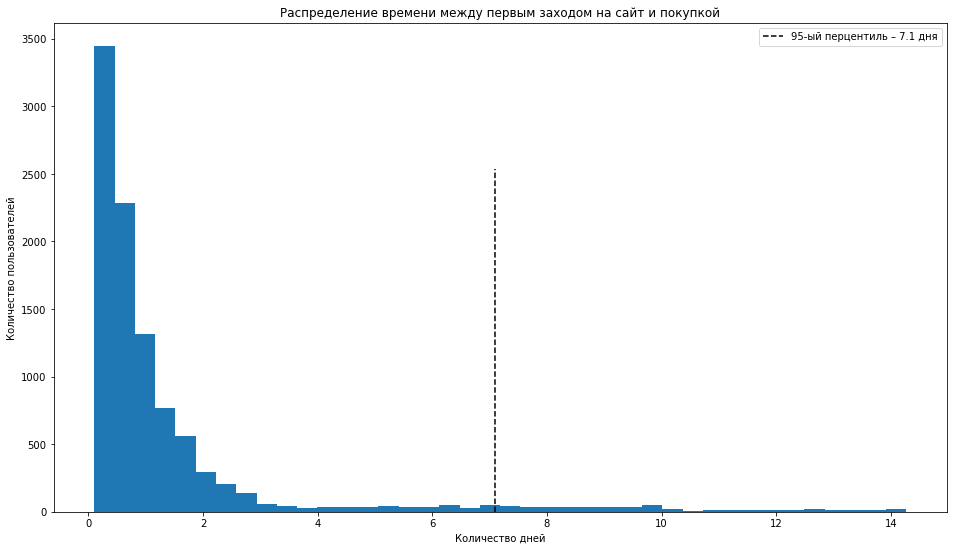

In [8]:
plt.figure(figsize=(16,9))

plt.hist(historical_data['time_to_order'], bins = 40)

plt.axvline(perc_95,
            ymin=0,
            ymax=0.7,
            color='k',
            linestyle='dashed',
            label=f'95-ый перцентиль – {perc_95} дня'
            )

plt.title('Распределение времени между первым заходом на сайт и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')

plt.legend()

plt.show()

**4. Делаем вывод об окне конверсии.**

Недельному окну конверсии соответствует 95-й процентиль распределения времени между первым заходом на сайт и покупкой.

## Задание 2. Исследование распределения пользователей по группам по основным сегментам 

**1. Подключаемся к данным A/B теста.**

In [9]:
data = pd.read_csv('bakery_ab_test.csv', index_col = 0)

data.head()

,user_id,test_group,purchase_amount,geo_group,acquisition_channel,within_window,platform
1,3738,test,306.639511,regions,target_direct,1,pc
2,3755,control,NaN,regions,target_direct,0,pc
3,3772,test,NaN,regions,context_brand,0,mobile
4,3789,control,NaN,spb,target_direct,0,pc
5,3806,test,NaN,regions,social_media,0,pc


**2. Создаем функцию plot_segment_distribution, чтобы проверить распределение пользователей по сегментам внутри каждой группы.**

In [10]:
def plot_segment_distribution(df, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = df.groupby(by = [test_factor, segment])['user_id'].count().reset_index()
        sns.catplot(x = segment, 
                    y = 'user_id', 
                    hue = test_factor, # разный цвет для групп
                    data = aggregated_data, 
                    kind = "bar", 
                    height = 4, # размер графика 
                    aspect = 1.5) # ширина столбца

**3. Строим графики при помощи созданной функции.**

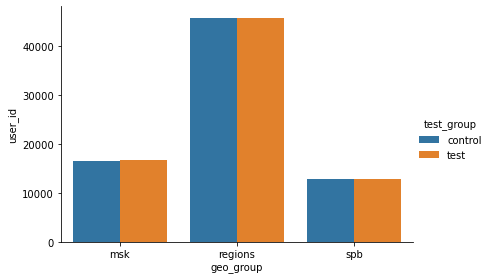

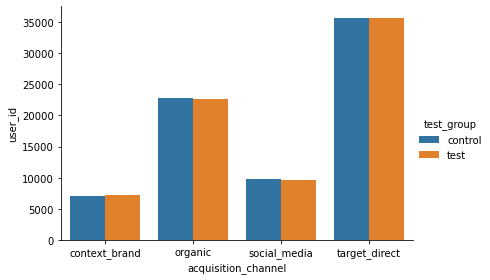

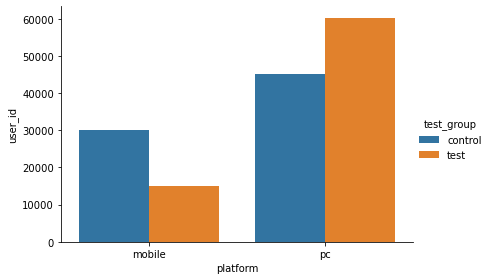

In [11]:
plot_segment_distribution(data, 
                          ["geo_group", "acquisition_channel", "platform"],
                          "test_group")

**4. Делаем вывод о качестве сплитования.**

В рамках сегментов `geo_group` и `acquisition_channel` группы распределены равномерно, в рамках сегмента `platform` распределение неравномерное.

## Задание 3. Критерий Хи-квадрат для конверсии


Мы не можем исправить данные, но можем проанализировать общие результаты и сравнить их с результатами для пользователей, зашедших с разных платформ, чтобы уменьшить риск принятия ошибочного решения. Поэтому дальше мы будем анализировать параллельно 3 теста:

1. Все пользователи, попавшие в тест
2. Пользователи, заходившие с ПК `platform = 'pc'`
3. Пользователи, заходившие с мобильного `platform = 'mobile'`

**1. Создаем для каждой из 3 групп теста отдельную таблицу с метриками.**

In [12]:
metrics = data.groupby('test_group', as_index= False)\
    .agg({'user_id': 'count', 'within_window': 'sum', 'purchase_amount': 'mean'}).reset_index()
metrics['conversion'] = round(100 * metrics['within_window'] / metrics['user_id'], 2)
metrics

,index,test_group,user_id,within_window,purchase_amount,conversion
0,0,control,75210,22998,5170.864335,30.58
1,1,test,75273,24427,5394.771589,32.45


In [13]:
metrics_pc = data.loc[data['platform'] == 'pc'].groupby('test_group', as_index= False)\
    .agg({'user_id': 'count', 'within_window': 'sum', 'purchase_amount': 'mean'}).reset_index()
metrics_pc['conversion'] = round(100 * metrics_pc['within_window'] / metrics_pc['user_id'], 2)
metrics_pc

,index,test_group,user_id,within_window,purchase_amount,conversion
0,0,control,45112,13732,5200.121803,30.44
1,1,test,60317,19659,5401.003720,32.59


In [14]:
metrics_mobile = data.loc[data['platform'] == 'mobile'].groupby('test_group', as_index= False)\
    .agg({'user_id': 'count', 'within_window': 'sum', 'purchase_amount': 'mean'}).reset_index()
metrics_mobile['conversion'] = round(100 * metrics_mobile['within_window'] / metrics_mobile['user_id'], 2)
metrics_mobile

,index,test_group,user_id,within_window,purchase_amount,conversion
0,0,control,30098,9266,5127.505438,30.79
1,1,test,14956,4768,5369.075812,31.88


**2. Вычисляем p-value для каждой группы с помощью теста хи-квадрат.**

In [15]:
import statsmodels.stats.proportion as proportion

In [16]:
chi2stat, pval, table = proportion.proportions_chisquare(metrics['within_window'], metrics['user_id'])

chi2stat_pc, pval_pc, table_pc = proportion.proportions_chisquare(metrics_pc['within_window'], metrics_pc['user_id'])

chi2stat_mobile, pval_mobile, table_mobile = proportion.proportions_chisquare(metrics_mobile['within_window'], metrics_mobile['user_id'])

**3. Вводим в анализ уровень значимости в 5% с помощью переменной alpha.**

In [17]:
alpha = 0.05

In [18]:
pval < alpha

True

In [19]:
pval_pc < alpha

True

In [20]:
pval_mobile < alpha

True

**4. Делаем вывод о наличии статистически значимой разницы в каждой группе.**

P-value во всех трех группах меньше заданного значения уровня значимости, поэтому мы принимаем нулевую гипотезу о том, что различий в конверсии нет (при условии достаточной мощности).

## Задание 4. Вычисление мощности теста

**1. Записываем значения конверсии в тестовой и контрольной группе в разные переменные.**

In [21]:
conversion_control = metrics['conversion'].values[0]/100
conversion_test = metrics['conversion'].values[1]/100

In [22]:
conversion_control_pc = metrics_pc['conversion'].values[0]/100
conversion_test_pc = metrics_pc['conversion'].values[1]/100

In [23]:
conversion_control_mobile = metrics_mobile['conversion'].values[0]/100
conversion_test_mobile = metrics_mobile['conversion'].values[1]/100

**2. Создаем переменную nobs для количества наблюдений и записываем в нее значение меньшей группы.**

In [24]:
nobs = min(metrics['user_id'])

In [25]:
nobs_pc = min(metrics_pc['user_id'])

In [26]:
nobs_mobile = min(metrics_mobile['user_id'])

**3. Создаем функцию для того, чтобы посчитать, насколько одна группа эффективнее другой в исследуемой метрике.**

In [27]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

**4. Вычисляем мощность для каждой группы, для которой делали тест хи-квадрат.**

In [28]:
import statsmodels.stats.power as power

In [29]:
chipower = power.GofChisquarePower()

In [30]:
power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control, conversion_test), # разница коэффициентов конверсии
                             nobs = nobs, # размер выборки
                             alpha = pval, # значение ошибки первого рода
                             power = None) # функция вернет значение, указаное как None
power

0.9271367916086642

In [31]:
pc_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_pc, conversion_test_pc), # разница коэффициентов конверсии
                                nobs = nobs_pc, # размер выборки
                                alpha = pval_pc, # значение ошибки первого рода
                                power = None) # функция вернет значение, указаное как None
pc_power

0.79997711974453

In [32]:
mobile_power = chipower.solve_power(effect_size = chi2_effect_size(conversion_control_mobile, conversion_test_mobile), # разница коэффициентов конверсии
                                    nobs = nobs_mobile, # размер выборки
                                    alpha = pval_mobile, # значение ошибки первого рода
                                    power = None) # функция вернет значение, указаное как None
mobile_power

0.51629109023244

**5. Делаем вывод о величине мощности в каждой группе.**

Мощность по всем пользователям больше 90%, в сегменте `'pc'` около 80%, в сегменте `'mobile'` гораздо ниже 80%, поэтому в случае последнего нельзя сделать достоверные выводы.

## Задание 5. Использование бутстрапа для оценки влияния теста на средний чек

**1. Записываем данные по суммам покупки в тестовой и контрольной группе в разные переменные.**

In [33]:
test = data[data['test_group'] == 'test']['purchase_amount'].dropna().values
control = data[data['test_group'] == 'control']['purchase_amount'].dropna().values

In [34]:
test_pc = data[(data['test_group'] == 'test') & (data['platform'] == 'pc')]['purchase_amount'].dropna().values
control_pc = data[(data['test_group'] == 'control') & (data['platform'] == 'pc')]['purchase_amount'].dropna().values

In [35]:
test_mobile = data[(data['test_group'] == 'test') & (data['platform'] == 'mobile')]['purchase_amount'].dropna().values
control_mobile = data[(data['test_group'] == 'control') & (data['platform'] == 'mobile')]['purchase_amount'].dropna().values

**2. Вызываем функцию bootstrap_ab для каждой из трех групп.**

In [36]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

In [37]:
boot = bs.bootstrap_ab(test = test, 
                       ctrl = control,
                       stat_func = bs_stats.mean,
                       compare_func = bs_compare.difference,
                       return_distribution=True)

In [38]:
boot_pc = bs.bootstrap_ab(test = test_pc, 
                          ctrl = control_pc,
                          stat_func = bs_stats.mean,
                          compare_func = bs_compare.difference,
                          return_distribution=True)

In [39]:
boot_mobile = bs.bootstrap_ab(test = test_mobile, 
                              ctrl = control_mobile,
                              stat_func = bs_stats.mean,
                              compare_func = bs_compare.difference,
                              return_distribution=True)

**3. Создаем функцию для визуализации результатов bootstrap теста.**

In [40]:
def plot_bootstrap_test(data, title):

    borders = np.percentile(data, [2.5, 97.5]) # задаем ширину 95%-ного доверительного интервала
    
    ax = sns.histplot(data)
    ax.set(xlabel=None, ylabel=None)
    
    plt.title(title, fontsize=12)
    plt.rcParams["figure.figsize"] = (10, 8)
    
    plt.axvline(0, # рисуем линию на уровне ноля
               ymin=0, 
               ymax=0.5, 
               linestyle='--', 
               color='red')
    
    plt.axvline(borders[0], # рисуем линию в начале доверительного интервала 
               ymin=0, 
               ymax=0.5, 
               linestyle='--', 
               color='grey', 
               label='95%-доверительный интервал')
    
    plt.axvline(borders[1], # рисуем линию в конце доверительного интервала
               ymin=0, 
               ymax=0.5, 
               linestyle='--', 
               color='grey')
    
    plt.legend(loc="upper right")
    
    plt.show()

**4. Визуализируем результат по всем группам при помощи созданной функции.**

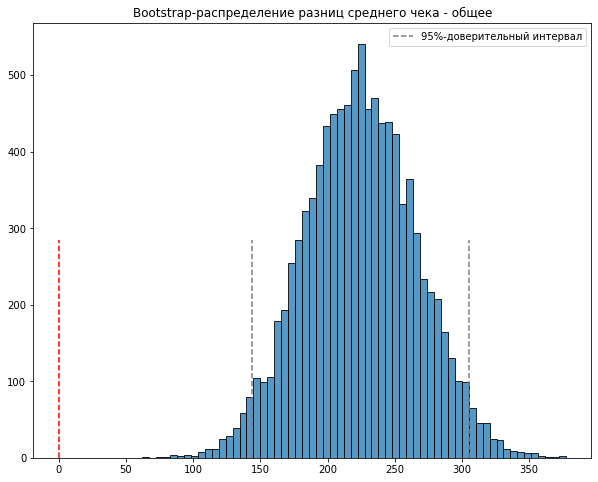

In [42]:
plot_bootstrap_test(data=boot,
                    title='Bootstrap-распределение разниц среднего чека - общее')

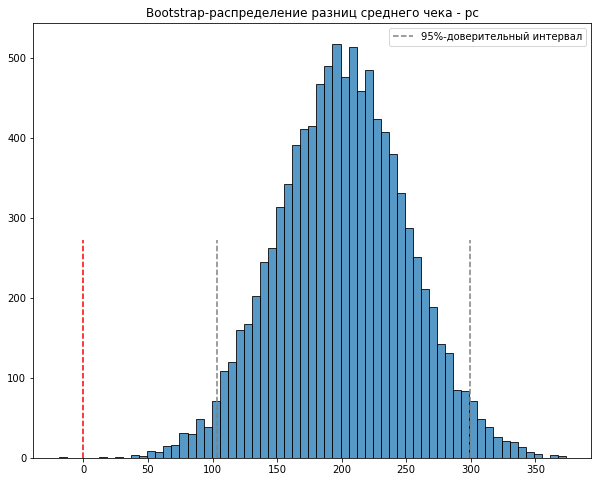

In [43]:
plot_bootstrap_test(data=boot_pc,
                    title='Bootstrap-распределение разниц среднего чека - pc')

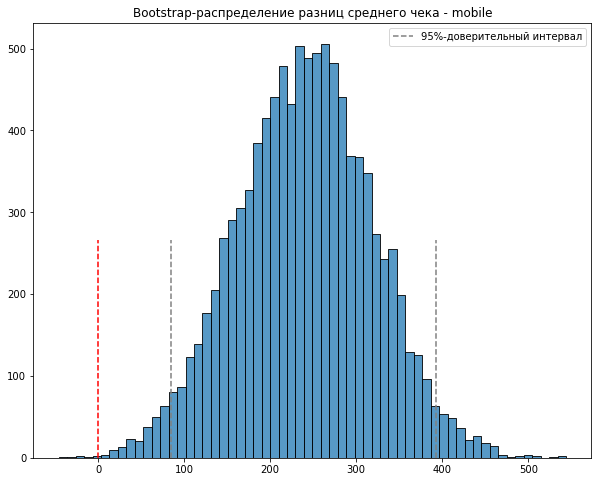

In [44]:
plot_bootstrap_test(data=boot_mobile,
                    title='Bootstrap-распределение разниц среднего чека - mobile')

**5. Делаем вывод о том, есть ли статистически значимое изменение среднего чека в каждой группе.**

Во всех трех случаях ноль не входит в доверительный интервал, значит есть статистически значимое изменение среднего чека. Во всех трех случаях средний чек увеличился.

## Задание 6. Вывод по результатам проведенного теста

Эксперимент нельзя считать успешным, т.к. статистически значимого измененения в конверсии нет. Но при этом есть статистически значимое увеличение среднего чека.

Т.к. есть ошибка в сплитовании (наблюдения неравномерно распределены на тестовую и контрольную группу в сегменте `platform`) и величина мощности недостаточна в тесте по группе `mobile`, эксперимент лучше повторить, исправив эти недостатки.